# Research Question No. 4
This research question aims to investigate the characteristics of groups of bugs for which classifiers yield better accuracy.

# 1. Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse, Freedesktop, Gcc, Gnome, Mozilla, WineHQ       |
| Algorithms                 | NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

# 2. Setup environment

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

pd.set_option('display.max_columns', None)

results_path = "datasets/20190926143854_rq3e4_all_predict_long_lived_tests_balanced_acc.csv"
reports_path = "datasets/20190917_gcc_bug_report_data.csv"
print("Setup complete")

Setup complete


# 3. Load data

In [3]:
    !echo "\nHeader of metrics file $reports_path"
    !head -n 2 $reports_path

    !echo "\nNumber of lines in the file $reports_path"
    !wc -l $reports_path
    
    !echo "\nHeader of metrics file $results_path"
    !head -n 2 $results_path

    !echo "\nNumber of lines in the file $results_path"
    !wc -l $results_path


Header of metrics file datasets/20190917_gcc_bug_report_data.csv
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font.getPSFontName() to return something non-null.,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2

Number of lines in the file datasets/20190917_gcc_bug_report_data.csv
489575 datasets/20190917_gcc_bug_report_data.csv

Header of metrics file datasets/20190926143854_rq3e4_all_predict_long_lived_tests_balanced_acc.csv
bug_id,bug_fix_time,long_lived,y_hat
CLASSPATH-16983,15,N,N

Number of lines in the file datasets/20190926143854_rq3e4_all_predict_long_lived_tests_balanced_acc.csv
2481

In [4]:
# read data.
reports_data  = pd.read_csv(reports_path)
rows_and_cols = reports_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_path}.\n")

results_data = pd.read_csv(results_path)
rows_and_cols = results_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_path}.\n")


There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

There are 2480 rows and 4 columns in datasets/20190917_gcc_bug_report_data.csv.



# 4. Test Results Analysis

### 4.1 Review data

In [5]:
results_data.head()

bug_id  bug_fix_time long_lived y_hat
0  CLASSPATH-16983            15          N     N
1  CLASSPATH-17008           342          N     N
2  CLASSPATH-17060           337          N     N
3  CLASSPATH-18312             5          N     N
4  CLASSPATH-21635            96          N     N

## 4.2 Results analysis

In [6]:
def plot_bar(data, status, column, ax):
    
    top_n = data[data['status_prediction']==status]
    top_n = top_n.groupby(column).size().reset_index(name='count')
    top_n = top_n.sort_values('count', ascending=False).head(10)
    top_n.plot(kind="bar", x=column, ax=ax)
    ax.set(title=f"prediction: {status}", xlabel="", ylabel="Count")
    ax.get_legend().remove()

In [7]:
results_merged_data = pd.merge(
    reports_data,
    results_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)

In [8]:
long_lived_predicted_bugs = results_merged_data.query('long_lived == "Y"')
long_lived_predicted_bugs.loc[:, 'status_prediction']  = long_lived_predicted_bugs.loc[:, 'y_hat'].apply(lambda t: 'correct' if t == 'Y' else 'incorrect')

/home/luiz/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/luiz/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Reporter Name

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)
sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_predicted_bugs, status, 'reporter_name', ax)

### Assignee

In [10]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)
sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_predicted_bugs, status, 'assignee_name', ax)

### Component Name

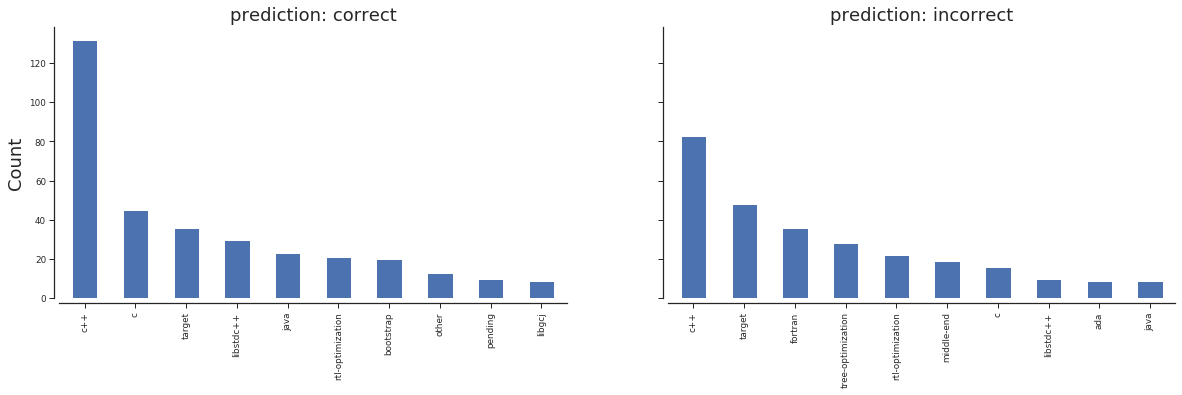

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)
sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_predicted_bugs, status, 'component_name', ax)

### Severity Level

In [12]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)
sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_predicted_bugs, status, 'severity_category', ax)

### Long Description 
Existem muitas palavras relacionadas com c√≥digo(stop words).

#### Word cloud

<table width="100%">
    <tbody>
        <tr>
            <td>Corrected</td>
            <td>Incorrected</td>
        </tr>
        <tr>
        <td>
<img src="datasets/wordcloud-gcc-corrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>
        </td>
        <td>
<img src="datasets/wordcloud-gcc-incorrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>            
        </td>
        </tr>
     </tbody>
</table>

#### Histograms 

<table width="100%">
    <tbody>
        <tr>
        <td>
<img src="datasets/histfreq-gcc-corrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>
        </td>
        <td>
<img src="datasets/histfreq-gcc-incorrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>            
        </td>
        </tr>
     </tbody>
</table>